# Initialization
Kami membagi pekerjaan nomor `1. Modelling` menjadi 4 jenis:
1. Logistic Regression menggunakan Data Transformasi Quantile
2. Logistic Regression menggunakan Data Transformasi Logaritmik
3. Model Lainnya menggunakan Data Transformasi Quantile
4. Model Lainnya menggunakan Data Transformasi Logaritmik

In [1]:
# Run to access the CSV file
!git clone https://github.com/refaniefs/rakamin.git

fatal: destination path 'rakamin' already exists and is not an empty directory.


In [2]:
# Run to install and import packages
!pip install --upgrade xlrd

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

## Function

In [4]:
def model_eval(clf, pred, xtrain, ytrain, xtest, ytest, ypredproba, ypredtrainproba):
    print("Score: ", round(clf.score(xtest, ytest),4))
    print("Accuracy (Test Set): ", round(accuracy_score(ytest, pred),4))
    print("Precision (Test Set): ", round(precision_score(ytest, pred),4))
    print("Recall (Test Set): ", round(recall_score(ytest, pred),4))
    print("F1-Score (Test Set): ", round(f1_score(ytest, pred),4))
    print('roc-auc (test-proba): ', round(roc_auc_score(ytest, ypredproba[:,1]),4))
    print('roc-auc (train-proba): ', round(roc_auc_score(ytrain, ypredtrainproba[:,1]),4))

## Preprocessed Data

In [5]:
df = pd.read_csv('shipping_fix.csv')

# use this instead if using google colab:
# df = pd.read_csv('/rakamin/final-project/shipping_fix.csv')

df = df.drop(columns=['Unnamed: 0'])
df.sample(5)

,Product_importance,Gender,Reached.on.Time_Y.N,Cost_of_the_Product_tr,Discount_offered_tr,Weight_in_gms_tr,Prior_purchases_tr,prior_purchase_std,product_cost_norm,discount_norm,...,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Cost_Per_Weight,Cost_After_Disc,Weight_level
6490,1,0,0,-1.378114,0.365531,0.634479,-5.199338,-1.323289,0.210280,0.526359,...,1,0,0,0,0,0,1,0.028200,132,1
4788,2,0,1,1.304121,-0.017565,0.387078,-0.211070,-0.255579,0.813084,0.466155,...,0,0,0,1,0,0,1,0.057569,263,1
9486,1,1,1,-1.689670,-1.207532,1.803394,1.037937,1.089577,0.177570,0.166048,...,0,0,0,0,0,0,1,0.022847,132,2
6599,1,0,0,-0.149853,-0.875354,0.033880,-0.211070,-0.255579,0.500000,0.263179,...,0,0,1,0,1,0,0,0.048379,200,1
1023,0,1,1,-1.199766,0.746351,-0.866189,0.506348,0.501974,0.238318,0.614449,...,0,0,0,0,0,0,1,0.088715,134,0


In [6]:
df.columns

Index(['Product_importance', 'Gender', 'Reached.on.Time_Y.N',
       'Cost_of_the_Product_tr', 'Discount_offered_tr', 'Weight_in_gms_tr',
       'Prior_purchases_tr', 'prior_purchase_std', 'product_cost_norm',
       'discount_norm', 'weight_norm', 'Warehouse_block_A',
       'Warehouse_block_B', 'Warehouse_block_C', 'Warehouse_block_D',
       'Warehouse_block_F', 'Mode_of_Shipment_Flight', 'Mode_of_Shipment_Road',
       'Mode_of_Shipment_Ship', 'Cost_Per_Weight', 'Cost_After_Disc',
       'Weight_level'],
      dtype='object')

In [7]:
# pengelompokan kolom berdasarkan jenis preprocessing
df_quantile = df.drop(columns = ['product_cost_norm','prior_purchase_std','discount_norm','weight_norm'])

df_log = df.drop(columns = ['Cost_of_the_Product_tr','Discount_offered_tr','Weight_in_gms_tr','Prior_purchases_tr'])

# [Soal Nomor 1] Modelling

# Jenis 1. Logistic Regression with Quantile Trf.

In [8]:
df_quantile_lr = df_quantile.drop(columns=['Warehouse_block_A','Mode_of_Shipment_Flight'])

## 1A. Split Data

In [9]:
# split data
X_qlr = df_quantile_lr.drop(columns=['Reached.on.Time_Y.N'])
y_qlr = df_quantile_lr[['Reached.on.Time_Y.N']]

X_qlr_train, X_qlr_test, y_qlr_train, y_qlr_test = train_test_split(X_qlr, y_qlr, test_size=0.3, random_state=42,stratify=y_qlr)

## 1B. Modelling

In [10]:
quantile_lr = LogisticRegression(random_state=42)

quantile_lr.fit(X_qlr_train, y_qlr_train)

LogisticRegression(random_state=42)

## 1C. Evaluation Metrics

In [11]:
y_qlr_pred = quantile_lr.predict(X_qlr_test)
y_qlr_pred_proba = quantile_lr.predict_proba(X_qlr_test)
y_qlr_pred_train = quantile_lr.predict(X_qlr_train)
y_qlr_pred_train_proba = quantile_lr.predict_proba(X_qlr_train)

model_eval(quantile_lr, y_qlr_pred, X_qlr_train, y_qlr_train, X_qlr_test, y_qlr_test, y_qlr_pred_proba, y_qlr_pred_train_proba)

Score:  0.65
Accuracy (Test Set):  0.65
Precision (Test Set):  0.6952
Recall (Test Set):  0.747
F1-Score (Test Set):  0.7202
roc-auc (test-proba):  0.7241
roc-auc (train-proba):  0.7302


## 1D. Apakah Model Sudah Best-fit?
Belum bestfit, score penting dapat ditingkatkan menggunakan hyperparameter tuning.

## 1E. Hyperparameter Tuning

In [12]:
hyperparameterqlr = {'penalty':['l1', 'l2'],
                    'C':[0.0001, 0.001, 0.1, 0.02, 0.03, 0.01],
                    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

quantile_lr = RandomizedSearchCV(LogisticRegression(random_state=42), hyperparameterqlr, cv=5, scoring='roc_auc')
quantile_lr.fit(X_qlr_train, y_qlr_train)

y_qlr_pred = quantile_lr.predict(X_qlr_test)
y_qlr_pred_proba = quantile_lr.predict_proba(X_qlr_test)
y_qlr_pred_train = quantile_lr.predict(X_qlr_train)
y_qlr_pred_train_proba = quantile_lr.predict_proba(X_qlr_train)

model_eval(quantile_lr, y_qlr_pred, X_qlr_train, y_qlr_train, X_qlr_test, y_qlr_test, y_qlr_pred_proba, y_qlr_pred_train_proba)
print('      ')
hpqlr = list(hyperparameterqlr)
for i in hpqlr:
    print('Best',i,':', quantile_lr.best_estimator_.get_params()[i])

Score:  0.7247
Accuracy (Test Set):  0.6425
Precision (Test Set):  0.6881
Recall (Test Set):  0.7442
F1-Score (Test Set):  0.7151
roc-auc (test-proba):  0.7247
roc-auc (train-proba):  0.7301
      
Best penalty : l2
Best C : 0.03
Best solver : liblinear


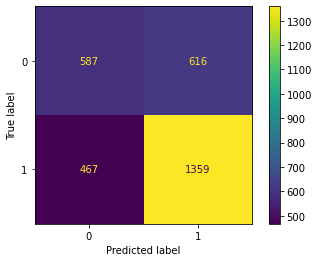

In [13]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(quantile_lr, X_qlr_test, y_qlr_test)

# Jenis 2. Logistic Regression with Logarithmic Trf.

In [14]:
df_log_lr = df_log.drop(columns=['Warehouse_block_A','Mode_of_Shipment_Flight'])

## 1A. Split Data

In [15]:
X_llr = df_log_lr.drop(columns=['Reached.on.Time_Y.N'])
y_llr = df_log_lr[['Reached.on.Time_Y.N']]

X_llr_train, X_llr_test, y_llr_train, y_llr_test = train_test_split(X_llr, y_llr, test_size=0.3, random_state=42,stratify=y_llr)

## 1B. Modelling

In [16]:
log_lr = LogisticRegression(random_state=42)

log_lr.fit(X_llr_train, y_llr_train)

LogisticRegression(random_state=42)

## 1C. Evaluation Metrics

In [17]:
y_llr_pred = log_lr.predict(X_llr_test)
y_llr_pred_proba = log_lr.predict_proba(X_llr_test)
y_llr_pred_train = log_lr.predict(X_llr_train)
y_llr_pred_train_proba = log_lr.predict_proba(X_llr_train)

model_eval(log_lr, y_llr_pred, X_llr_train, y_llr_train, X_llr_test, y_llr_test, y_llr_pred_proba, y_llr_pred_train_proba)

Score:  0.6474
Accuracy (Test Set):  0.6474
Precision (Test Set):  0.7007
Recall (Test Set):  0.7245
F1-Score (Test Set):  0.7124
roc-auc (test-proba):  0.7306
roc-auc (train-proba):  0.7355


## 1D. Apakah Model Sudah Best-fit?
Belum bestfit, score penting dapat ditingkatkan menggunakan hyperparameter tuning.

## 1E. Hyperparameter Tuning

In [18]:
hyperparameterllr = {'penalty':['l1', 'l2'],
                    'C':[0.0001, 0.001, 0.1, 0.02, 0.03, 0.01],
                    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

log_lr = RandomizedSearchCV(LogisticRegression(random_state=42), hyperparameterllr, cv=5, scoring='roc_auc')
log_lr.fit(X_llr_train, y_llr_train)

y_llr_pred = log_lr.predict(X_llr_test)
y_llr_pred_proba = log_lr.predict_proba(X_llr_test)
y_llr_pred_train = log_lr.predict(X_llr_train)
y_llr_pred_train_proba = log_lr.predict_proba(X_llr_train)

model_eval(log_lr, y_llr_pred, X_llr_train, y_llr_train, X_llr_test, y_llr_test, y_llr_pred_proba, y_llr_pred_train_proba)
print('      ')
hpllr = list(hyperparameterllr)
for i in hpllr:
    print('Best',i,':', log_lr.best_estimator_.get_params()[i])

Score:  0.73
Accuracy (Test Set):  0.6467
Precision (Test Set):  0.6933
Recall (Test Set):  0.7426
F1-Score (Test Set):  0.7171
roc-auc (test-proba):  0.73
roc-auc (train-proba):  0.7373
      
Best penalty : l2
Best C : 0.1
Best solver : liblinear


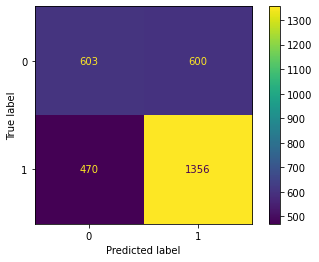

In [19]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(log_lr, X_llr_test, y_llr_test)

# Jenis 3. Quantile Trf Cases

## 1A. Split Data

In [20]:
X_q = df_quantile.drop(columns=['Reached.on.Time_Y.N'])
y_q = df_quantile[['Reached.on.Time_Y.N']]

X_q_train, X_q_test, y_q_train, y_q_test = train_test_split(X_q, y_q, test_size=0.3, random_state=42,stratify=y_q)

## 1B. Modelling

In [21]:
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    # "Support Vector Machine (RBF Kernel)": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGboost": XGBClassifier(random_state=42)
}

## 1C. Evaluation Metrics

In [22]:
for name, model in models.items():
    model.fit(X_q_train, y_q_train)
    y_q_pred = model.predict(X_q_test)
    y_q_pred_proba = model.predict_proba(X_q_test)
    y_q_pred_train = model.predict(X_q_train)
    y_q_pred_train_proba = model.predict_proba(X_q_train)
    print(name)
    print('          ')
    model_eval(model, y_q_pred, X_q_train, y_q_train, X_q_test, y_q_test, y_q_pred_proba, y_q_pred_train_proba)
    print('          ')
    print('==========================================================')
    print('          ')

K-Nearest Neighbors
          
Score:  0.6395
Accuracy (Test Set):  0.6395
Precision (Test Set):  0.7139
Recall (Test Set):  0.6709
F1-Score (Test Set):  0.6917
roc-auc (test-proba):  0.6969
roc-auc (train-proba):  0.8579
          
          
Decision Tree
          
Score:  0.6458
Accuracy (Test Set):  0.6458
Precision (Test Set):  0.7072
Recall (Test Set):  0.7037
F1-Score (Test Set):  0.7055
roc-auc (test-proba):  0.6307
roc-auc (train-proba):  1.0
          
          
Random Forest
          
Score:  0.654
Accuracy (Test Set):  0.654
Precision (Test Set):  0.7529
Recall (Test Set):  0.6342
F1-Score (Test Set):  0.6885
roc-auc (test-proba):  0.7359
roc-auc (train-proba):  1.0
          
          
Gradient Boosting
          
Score:  0.6758
Accuracy (Test Set):  0.6758
Precision (Test Set):  0.8505
Recall (Test Set):  0.5608
F1-Score (Test Set):  0.6759
roc-auc (test-proba):  0.7326
roc-auc (train-proba):  0.8406
          
          
Gaussian Naive Bayes
          
Score:  0.659


## 1D. Apakah Model Sudah Best-fit?
Belum bestfit, score penting dapat ditingkatkan menggunakan hyperparameter tuning.

## 1E. Hyperparameter Tuning

In [23]:
# LogisticRegression Hyperparameter Tuning
hyperparameterlr = {'penalty' : ['l1', 'l2'],
                    'C' : [0.0001, 0.001, 0.1, 0.02, 0.03, 0.01], 
                    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                   }

# DesicionTree Hyperparameter Tuning
hyperparameterdt = {'max_depth' : [int(x) for x in np.linspace(1, 100, num = 30)], # Maximum number of levels in tree, 
                    'min_samples_split' : [2, 5, 10, 100], # Minimum number of samples required to split a node, 
                    'min_samples_leaf' : [1, 2, 4, 10, 20, 50], # Minimum number of samples required at each leaf node,
                    'max_features' : ['auto', 'sqrt','log2'] # Number of features to consider at every split
                    }

# RandomForest Hyperparameter Tuning
hyperparameterrf = {'n_estimators' : [int(x) for x in np.linspace(1, 10, num = 10)],
                    'max_depth' : [int(x) for x in np.linspace(1, 10, num = 3)], # Maximum number of levels in tree
                    'min_samples_split' : [int(x) for x in np.linspace(1, 40, num = 30)], # Minimum number of samples required to split a node
                    'min_samples_leaf' : [int(x) for x in np.linspace(1, 20, num = 30)], # Minimum number of samples required at each leaf node
                    'max_features' : ['auto', 'sqrt','log2'], # Number of features to consider at every split
                    'criterion' : ['gini', 'entropy']
                   }

# K-Nearest Neighbors Hyperparameter Tuning]
hyperparameterkn = {'leaf_size' : list(range(1,50)),
                    'n_neighbors' : list(range(1,30)),
                    'p' : [1,2]
                   }

# Gaussian Naive Bayes Hyperparameter Tuning
hyperparameterNB = {'var_smoothing' : [int(x) for x in np.linspace(0,100, num=10)] 
                   }

# Gradient Boosting hyperparameter Tuning
hyperparametergb = {'n_estimators' : [2,6,8,10],
                    'max_depth' : [int(x) for x in np.linspace(1, 100, num = 5)], # Maximum number of levels in tree
                    'learning_rate' : [0.01,0.1,1,10]
                   }

# # Adaboost hyperparameter Tuning
# n_estimators = [int(x) for x in np.linspace(100, 2000, 1000)],
# learning_rate = [float(x) for x in np.linspace(0.001, 0.1, 100)],
# algorithm = ['SAMME', 'SAMME.R']
# hyperparameterab = dict(
#                         n_estimators = n_estimators,
#                         algorithm = algorithm, 
#                         learning_rate = learning_rate 
#                         )

# XGBoost hyperparameter Tuning
hyperparameterxgb = {'max_depth' : [int(x) for x in np.linspace(10, 50, 10)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 10, 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],
                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, 11)],
                    'learning_rate' : [float(x) for x in np.linspace(0, 1, 100)],
                    'reg_lambda' : [float(x) for x in np.linspace(0, 1, 11)],
                    'reg_alpha' : [float(x) for x in np.linspace(0, 1, 11)],
                    }

In [24]:
models = {
    "K-Nearest Neighbors tuned": RandomizedSearchCV(KNeighborsClassifier(), hyperparameterkn, cv=5, scoring='roc_auc'),
    "Decision Tree tuned": RandomizedSearchCV(DecisionTreeClassifier(random_state = 42), hyperparameterdt, cv=5, scoring='roc_auc'),
    # "Support Vector Machine (RBF Kernel)": SVC(),
    "Random Forest tuned": RandomizedSearchCV(RandomForestClassifier(random_state = 42), hyperparameterrf, cv=5, scoring='roc_auc'),
    "Gradient Boosting tuned": RandomizedSearchCV(GradientBoostingClassifier(random_state = 42), hyperparametergb, cv=5, scoring='roc_auc'),
    "Gaussian Naive Bayes tuned": RandomizedSearchCV(GaussianNB(), hyperparameterNB, cv=5, verbose=1, scoring='roc_auc'),
    # "AdaBoost tuned": RandomizedSearchCV(AdaBoostClassifier(random_state = 42), hyperparametergb, cv=5, scoring='roc_auc'),
    "XGboost tuned": RandomizedSearchCV(XGBClassifier(random_state = 42), hyperparametergb, cv=5, scoring='roc_auc')
}

In [25]:
for name, model in models.items():
    model.fit(X_q_train, y_q_train)
    y_q_pred = model.predict(X_q_test)
    y_q_pred_proba = model.predict_proba(X_q_test)
    y_q_pred_train = model.predict(X_q_train)
    y_q_pred_train_proba = model.predict_proba(X_q_train)
    print(name)
    print('          ')
    model_eval(model, y_q_pred, X_q_train, y_q_train, X_q_test, y_q_test, y_q_pred_proba, y_q_pred_train_proba)
    print('          ')
    print('==========================================================')
    print('          ')

K-Nearest Neighbors tuned
          
Score:  0.7191
Accuracy (Test Set):  0.6431
Precision (Test Set):  0.7365
Recall (Test Set):  0.6353
F1-Score (Test Set):  0.6822
roc-auc (test-proba):  0.7191
roc-auc (train-proba):  0.7927
          
          
Decision Tree tuned
          
Score:  0.7383
Accuracy (Test Set):  0.65
Precision (Test Set):  0.7415
Recall (Test Set):  0.644
F1-Score (Test Set):  0.6893
roc-auc (test-proba):  0.7383
roc-auc (train-proba):  0.829
          
          
Random Forest tuned
          
Score:  0.7409
Accuracy (Test Set):  0.6728
Precision (Test Set):  0.818
Recall (Test Set):  0.5882
F1-Score (Test Set):  0.6843
roc-auc (test-proba):  0.7409
roc-auc (train-proba):  0.8393
          
          
Gradient Boosting tuned
          
Score:  0.7369
Accuracy (Test Set):  0.6028
Precision (Test Set):  0.6028
Recall (Test Set):  1.0
F1-Score (Test Set):  0.7522
roc-auc (test-proba):  0.7369
roc-auc (train-proba):  0.7468
          
          
Fitting 5 folds for ea

# Jenis 4. Logarithmic Trf Cases

## 1A. Split Data

In [26]:
X_l = df_log.drop(columns=['Reached.on.Time_Y.N'])
y_l = df_log[['Reached.on.Time_Y.N']]

X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.3, random_state=42,stratify=y_l)

## 1B. Modelling

In [27]:
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    # "Support Vector Machine (RBF Kernel)": SVC(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGboost": XGBClassifier(random_state=42)
}


## 1C. Evaluation Metrics

In [28]:
for name, model in models.items():
    model.fit(X_l_train, y_l_train)
    y_l_pred = model.predict(X_l_test)
    y_l_pred_proba = model.predict_proba(X_l_test)
    y_l_pred_train = model.predict(X_l_train)
    y_l_pred_train_proba = model.predict_proba(X_l_train)
    print(name)
    print('          ')
    model_eval(model, y_l_pred, X_l_train, y_l_train, X_l_test, y_l_test, y_l_pred_proba, y_l_pred_train_proba)
    print('          ')
    print('==========================================================')
    print('          ')

K-Nearest Neighbors
          
Score:  0.6144
Accuracy (Test Set):  0.6144
Precision (Test Set):  0.6836
Recall (Test Set):  0.6709
F1-Score (Test Set):  0.6772
roc-auc (test-proba):  0.6533
roc-auc (train-proba):  0.8347
          
          
Decision Tree
          
Score:  0.651
Accuracy (Test Set):  0.651
Precision (Test Set):  0.7082
Recall (Test Set):  0.7163
F1-Score (Test Set):  0.7122
roc-auc (test-proba):  0.6341
roc-auc (train-proba):  1.0
          
          
Random Forest
          
Score:  0.6576
Accuracy (Test Set):  0.6576
Precision (Test Set):  0.753
Recall (Test Set):  0.6429
F1-Score (Test Set):  0.6936
roc-auc (test-proba):  0.7361
roc-auc (train-proba):  1.0
          
          
Gradient Boosting
          
Score:  0.6761
Accuracy (Test Set):  0.6761
Precision (Test Set):  0.8512
Recall (Test Set):  0.5608
F1-Score (Test Set):  0.6761
roc-auc (test-proba):  0.7324
roc-auc (train-proba):  0.8406
          
          
Gaussian Naive Bayes
          
Score:  0.6705


## 1D. Apakah Model Sudah Best-fit?
Belum bestfit, score penting dapat ditingkatkan menggunakan hyperparameter tuning.

## 1E. Hyperparameter Tuning

In [29]:
# LogisticRegression Hyperparameter Tuning
hyperparameterlr = {'penalty' : ['l1', 'l2'],
                    'C' : [0.0001, 0.001, 0.1, 0.02, 0.03, 0.01], 
                    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                   }

# DesicionTree Hyperparameter Tuning
hyperparameterdt = {'max_depth' : [int(x) for x in np.linspace(1, 100, num = 30)], # Maximum number of levels in tree, 
                    'min_samples_split' : [2, 5, 10, 100], # Minimum number of samples required to split a node, 
                    'min_samples_leaf' : [1, 2, 4, 10, 20, 50], # Minimum number of samples required at each leaf node,
                    'max_features' : ['auto', 'sqrt','log2'] # Number of features to consider at every split
                    }

# RandomForest Hyperparameter Tuning
hyperparameterrf = {'n_estimators' : [int(x) for x in np.linspace(1, 10, num = 10)],
                    'max_depth' : [int(x) for x in np.linspace(1, 10, num = 3)], # Maximum number of levels in tree
                    'min_samples_split' : [int(x) for x in np.linspace(1, 40, num = 30)], # Minimum number of samples required to split a node
                    'min_samples_leaf' : [int(x) for x in np.linspace(1, 20, num = 30)], # Minimum number of samples required at each leaf node
                    'max_features' : ['auto', 'sqrt','log2'], # Number of features to consider at every split
                    'criterion' : ['gini', 'entropy']
                   }

# K-Nearest Neighbors Hyperparameter Tuning]
hyperparameterkn = {'leaf_size' : list(range(1,50)),
                    'n_neighbors' : list(range(1,30)),
                    'p' : [1,2]
                   }

# Gaussian Naive Bayes Hyperparameter Tuning
hyperparameterNB = {'var_smoothing' : [int(x) for x in np.linspace(0,100, num=10)] 
                   }

# Gradient Boosting hyperparameter Tuning
hyperparametergb = {'n_estimators' : [2,6,8,10],
                    'max_depth' : [int(x) for x in np.linspace(1, 100, num = 5)], # Maximum number of levels in tree
                    'learning_rate' : [0.01,0.1,1,10]
                   }

# # Adaboost hyperparameter Tuning
# n_estimators = [int(x) for x in np.linspace(100, 2000, 1000)],
# learning_rate = [float(x) for x in np.linspace(0.001, 0.1, 100)],
# algorithm = ['SAMME', 'SAMME.R']
# hyperparameterab = dict(
#                         n_estimators = n_estimators,
#                         algorithm = algorithm, 
#                         learning_rate = learning_rate 
#                         )

# XGBoost hyperparameter Tuning
hyperparameterxgb = {'max_depth' : [int(x) for x in np.linspace(10, 50, 10)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 10, 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],
                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, 11)],
                    'learning_rate' : [float(x) for x in np.linspace(0, 1, 100)],
                    'reg_lambda' : [float(x) for x in np.linspace(0, 1, 11)],
                    'reg_alpha' : [float(x) for x in np.linspace(0, 1, 11)],
                    }

In [30]:
models = {
    "K-Nearest Neighbors tuned": RandomizedSearchCV(KNeighborsClassifier(), hyperparameterkn, cv=5, scoring='roc_auc'),
    "Decision Tree tuned": RandomizedSearchCV(DecisionTreeClassifier(random_state = 42), hyperparameterdt, cv=5, scoring='roc_auc'),
    # "Support Vector Machine (RBF Kernel)": SVC(),
    "Random Forest tuned": RandomizedSearchCV(RandomForestClassifier(random_state = 42), hyperparameterrf, cv=5, scoring='roc_auc'),
    "Gradient Boosting tuned": RandomizedSearchCV(GradientBoostingClassifier(random_state = 42), hyperparametergb, cv=5, scoring='roc_auc'),
    "Gaussian Naive Bayes tuned": RandomizedSearchCV(GaussianNB(), hyperparameterNB, cv=5, verbose=1, scoring='roc_auc'),
    # "AdaBoost tuned": RandomizedSearchCV(AdaBoostClassifier(random_state = 42), hyperparametergb, cv=5, scoring='roc_auc'),
    "XGboost tuned": RandomizedSearchCV(XGBClassifier(random_state = 42), hyperparametergb, cv=5, scoring='roc_auc')
}

In [31]:
for name, model in models.items():
    model.fit(X_l_train, y_l_train)
    y_l_pred = model.predict(X_l_test)
    y_l_pred_proba = model.predict_proba(X_l_test)
    y_l_pred_train = model.predict(X_l_train)
    y_l_pred_train_proba = model.predict_proba(X_l_train)
    print(name)
    print('          ')
    model_eval(model, y_l_pred, X_l_train, y_l_train, X_l_test, y_l_test, y_l_pred_proba, y_l_pred_train_proba)
    print('          ')
    print('==========================================================')
    print('          ')

K-Nearest Neighbors tuned
          
Score:  0.6949
Accuracy (Test Set):  0.621
Precision (Test Set):  0.6747
Recall (Test Set):  0.7169
F1-Score (Test Set):  0.6952
roc-auc (test-proba):  0.6949
roc-auc (train-proba):  0.766
          
          
Decision Tree tuned
          
Score:  0.7271
Accuracy (Test Set):  0.6464
Precision (Test Set):  0.7289
Recall (Test Set):  0.6583
F1-Score (Test Set):  0.6918
roc-auc (test-proba):  0.7271
roc-auc (train-proba):  0.8396
          
          
Random Forest tuned
          
Score:  0.7269
Accuracy (Test Set):  0.6633
Precision (Test Set):  0.8292
Recall (Test Set):  0.5559
F1-Score (Test Set):  0.6656
roc-auc (test-proba):  0.7269
roc-auc (train-proba):  0.8564
          
          
Gradient Boosting tuned
          
Score:  0.7362
Accuracy (Test Set):  0.6718
Precision (Test Set):  0.8925
Recall (Test Set):  0.5181
F1-Score (Test Set):  0.6556
roc-auc (test-proba):  0.7362
roc-auc (train-proba):  0.7638
          
          
Fitting 5 folds 

# [Best Model]

Dari sekian model yang dicoba di atas, best model adalah model Logistic Regression. Kedua cara preprocessing tidak terlihat terlalu memengaruhi score dari model.

Kami memprioritaskan:
1. AUC score yang tinggi dan tidak memiliki perbedaan jauh di antara AUC-train dan AUC-test
2. AUC-train < 1.00
3. Recall score

Model Logistic Regression dengan Transformasi Logarithmic:
- Score:  0.73
- Accuracy (Test Set):  0.6467
- Precision (Test Set):  0.6933
- Recall (Test Set):  0.7426
- F1-Score (Test Set):  0.7171
- roc-auc (test-proba):  0.73
- roc-auc (train-proba):  0.7373

Best Parameters:
- Best penalty : l2
- Best C : 0.1
- Best solver : liblinear

# [Soal Nomor 2] Feature Importance

## 2A. Feature Importance

In [32]:
best_llr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear',random_state=42)
best_llr.fit(X_llr_train, y_llr_train)

importance_llr = best_llr.coef_[0]

In [45]:
# summarize feature importance
feats_i = []
feats = []
feats_s = []
for i,v in enumerate(importance_llr):
    feats_i.append(i+1)
    feats.append(X_llr_train.columns[i])
    feats_s.append(v)
    
feat_imp = pd.DataFrame({
#    '#': feats_i,
    'Feature': feats,
    'Score' : feats_s
})
#	print('Feature',i,':', X_llr_train.columns[i],'\nScore:',v,'\n------------------')

feat_imp

,Feature,Score
0,Product_importance,0.138431
1,Gender,0.103564
2,prior_purchase_std,-0.180974
3,product_cost_norm,1.409413
4,discount_norm,2.610242
5,weight_norm,-0.210436
6,Warehouse_block_B,0.172538
7,Warehouse_block_C,0.194155
8,Warehouse_block_D,0.158731
9,Warehouse_block_F,0.134506


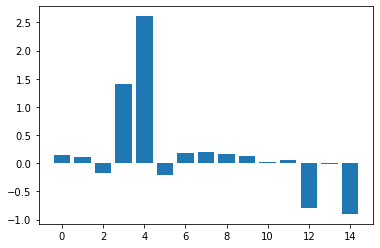

In [44]:
# plot feature importance
plt.bar([x for x in range(len(importance_llr))], importance_llr)
plt.show()

Dari grafik di atas, fitur `discount_norm` dan `product_cost_norm` sangat memengaruhi keterlambatan produk sampai dan `Weight_level` dan `Cost_Per_Weight` sangat memengaruhi ketepatan waktu produk sampai.

Semakin tinggi diskon yang ditawarkan ternyata semakin tinggi juga potensi keterlambatan, asumsinya adalah perusahaan mengabaikan service kepada customer karena sudah diberikan diskon.

## 2B. Feature Selection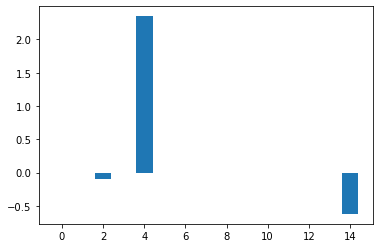

In [40]:
X_llr_2 = df_log_lr[['discount_norm','product_cost_norm','Weight_level','Cost_Per_Weight']]
y_llr_2 = df_log_lr[['Reached.on.Time_Y.N']]

X_llr_2_train, X_llr_2_test, y_llr_2_train, y_llr_2_test = train_test_split(X_llr_2, y_llr_2, test_size=0.3, random_state=42,stratify=y_llr_2)

In [41]:
best_llr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear',random_state=42)
best_llr.fit(X_llr_2_train, y_llr_2_train)

y_llr_2_pred = best_llr.predict(X_llr_2_test)
y_llr_2_pred_proba = best_llr.predict_proba(X_llr_2_test)
y_llr_2_pred_train = best_llr.predict(X_llr_2_train)
y_llr_2_pred_train_proba = best_llr.predict_proba(X_llr_2_train)

model_eval(best_llr, y_llr_2_pred, X_llr_2_train, y_llr_2_train, X_llr_2_test, y_llr_2_test, y_llr_2_pred_proba, y_llr_2_pred_train_proba)

Score:  0.6349
Accuracy (Test Set):  0.6349
Precision (Test Set):  0.676
Recall (Test Set):  0.7574
F1-Score (Test Set):  0.7144
roc-auc (test-proba):  0.7294
roc-auc (train-proba):  0.7322


Setelah melakukan iterasi model sesuai dengan best parameters, nilai AUC-test turun dari 73% menjadi 72.94%, AUC-train turun dari 73.73% menjadi 73.22%, dan nilai Recall naik dari 74.26% ke 75.74%.

Walaupun Feature Selection hanya menggunakan 4 fitur, penurunan nilai kedua score AUC tidak terlalu signifikan dan peningkatan nilai Recall cukup besar.

# [Soal Nomor 3] Git

Link Github:
https://github.com/refaniefs/rakamin/tree/main/final-project

# SELESAI